<a href="https://colab.research.google.com/github/katopz/DS_Portfolio/blob/master/credit_card_fraud/02_kaggle_creditcardfraud_modeling_final_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install shap

     |████████████████████████████████| 327kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456452 sha256=e27181f19e61e746839b43a0c4e4f8a7aac718a4176db7dd0df9e87e44aa5975
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.tree import export_graphviz
import pydot

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import imblearn.pipeline

from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_tree

from hyperopt import hp
from hyperopt import fmin, tpe

%matplotlib inline
plt.style.use('ggplot')

In [3]:
shap.initjs()

# EDA

## Authen

In [4]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


## Import Data

In [5]:
%%time
# df = pd.read_csv('./creditcardfraud_data.csv')
sql = """
SELECT * FROM `bigquery-public-data.ml_datasets.ulb_fraud_detection`
"""

# Run a Standard SQL query with the project set explicitly
project_id = 'sandbox-293504'
df = pd.read_gbq(sql, project_id=project_id, dialect='standard')

CPU times: user 28.1 s, sys: 1.8 s, total: 29.9 s
Wall time: 1min 28s


In [26]:
df.shape

(284807, 31)

In [27]:
df.head()

Time        V1        V2        V3  ...       V27       V28  Amount  Class
0  282.0 -0.356466  0.725418  1.971749  ... -0.043150 -0.046401     0.0      0
1  380.0 -1.299837  0.881817  1.452842  ...  0.234872  0.021379     0.0      0
2  403.0  1.237413  0.512365  0.687746  ... -0.066884  0.012986     0.0      0
3  430.0 -1.860258 -0.629859  0.966570  ... -0.043007 -0.223739     0.0      0
4  711.0 -0.431349  1.027694  2.670816  ...  0.101117  0.077944     0.0      0

[5 rows x 31 columns]

In [6]:
# Convert all columns to lower case
df.columns = [col.lower() for col in df.columns]

df.head()

time        v1        v2        v3  ...       v27       v28  amount  class
0  282.0 -0.356466  0.725418  1.971749  ... -0.043150 -0.046401     0.0      0
1  380.0 -1.299837  0.881817  1.452842  ...  0.234872  0.021379     0.0      0
2  403.0  1.237413  0.512365  0.687746  ... -0.066884  0.012986     0.0      0
3  430.0 -1.860258 -0.629859  0.966570  ... -0.043007 -0.223739     0.0      0
4  711.0 -0.431349  1.027694  2.670816  ...  0.101117  0.077944     0.0      0

[5 rows x 31 columns]

## Basic Checks for Nulls & Descriptive Statistics

In [29]:
# Check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    284807 non-null  float64
 1   v1      284807 non-null  float64
 2   v2      284807 non-null  float64
 3   v3      284807 non-null  float64
 4   v4      284807 non-null  float64
 5   v5      284807 non-null  float64
 6   v6      284807 non-null  float64
 7   v7      284807 non-null  float64
 8   v8      284807 non-null  float64
 9   v9      284807 non-null  float64
 10  v10     284807 non-null  float64
 11  v11     284807 non-null  float64
 12  v12     284807 non-null  float64
 13  v13     284807 non-null  float64
 14  v14     284807 non-null  float64
 15  v15     284807 non-null  float64
 16  v16     284807 non-null  float64
 17  v17     284807 non-null  float64
 18  v18     284807 non-null  float64
 19  v19     284807 non-null  float64
 20  v20     284807 non-null  float64
 21  v21     28

In [30]:
df.describe()

time            v1  ...         amount          class
count  284807.000000  2.848070e+05  ...  284807.000000  284807.000000
mean    94813.859575  1.557801e-15  ...      88.349619       0.001727
std     47488.145955  1.958696e+00  ...     250.120109       0.041527
min         0.000000 -5.640751e+01  ...       0.000000       0.000000
25%     54201.500000 -9.203734e-01  ...       5.600000       0.000000
50%     84692.000000  1.810880e-02  ...      22.000000       0.000000
75%    139320.500000  1.315642e+00  ...      77.165000       0.000000
max    172792.000000  2.454930e+00  ...   25691.160000       1.000000

[8 rows x 31 columns]

## Pairplots of Features and Target Variable

In [7]:
# Define all features
orig_feats = [col for col in df.columns if 'class' not in col]

len(orig_feats)

30

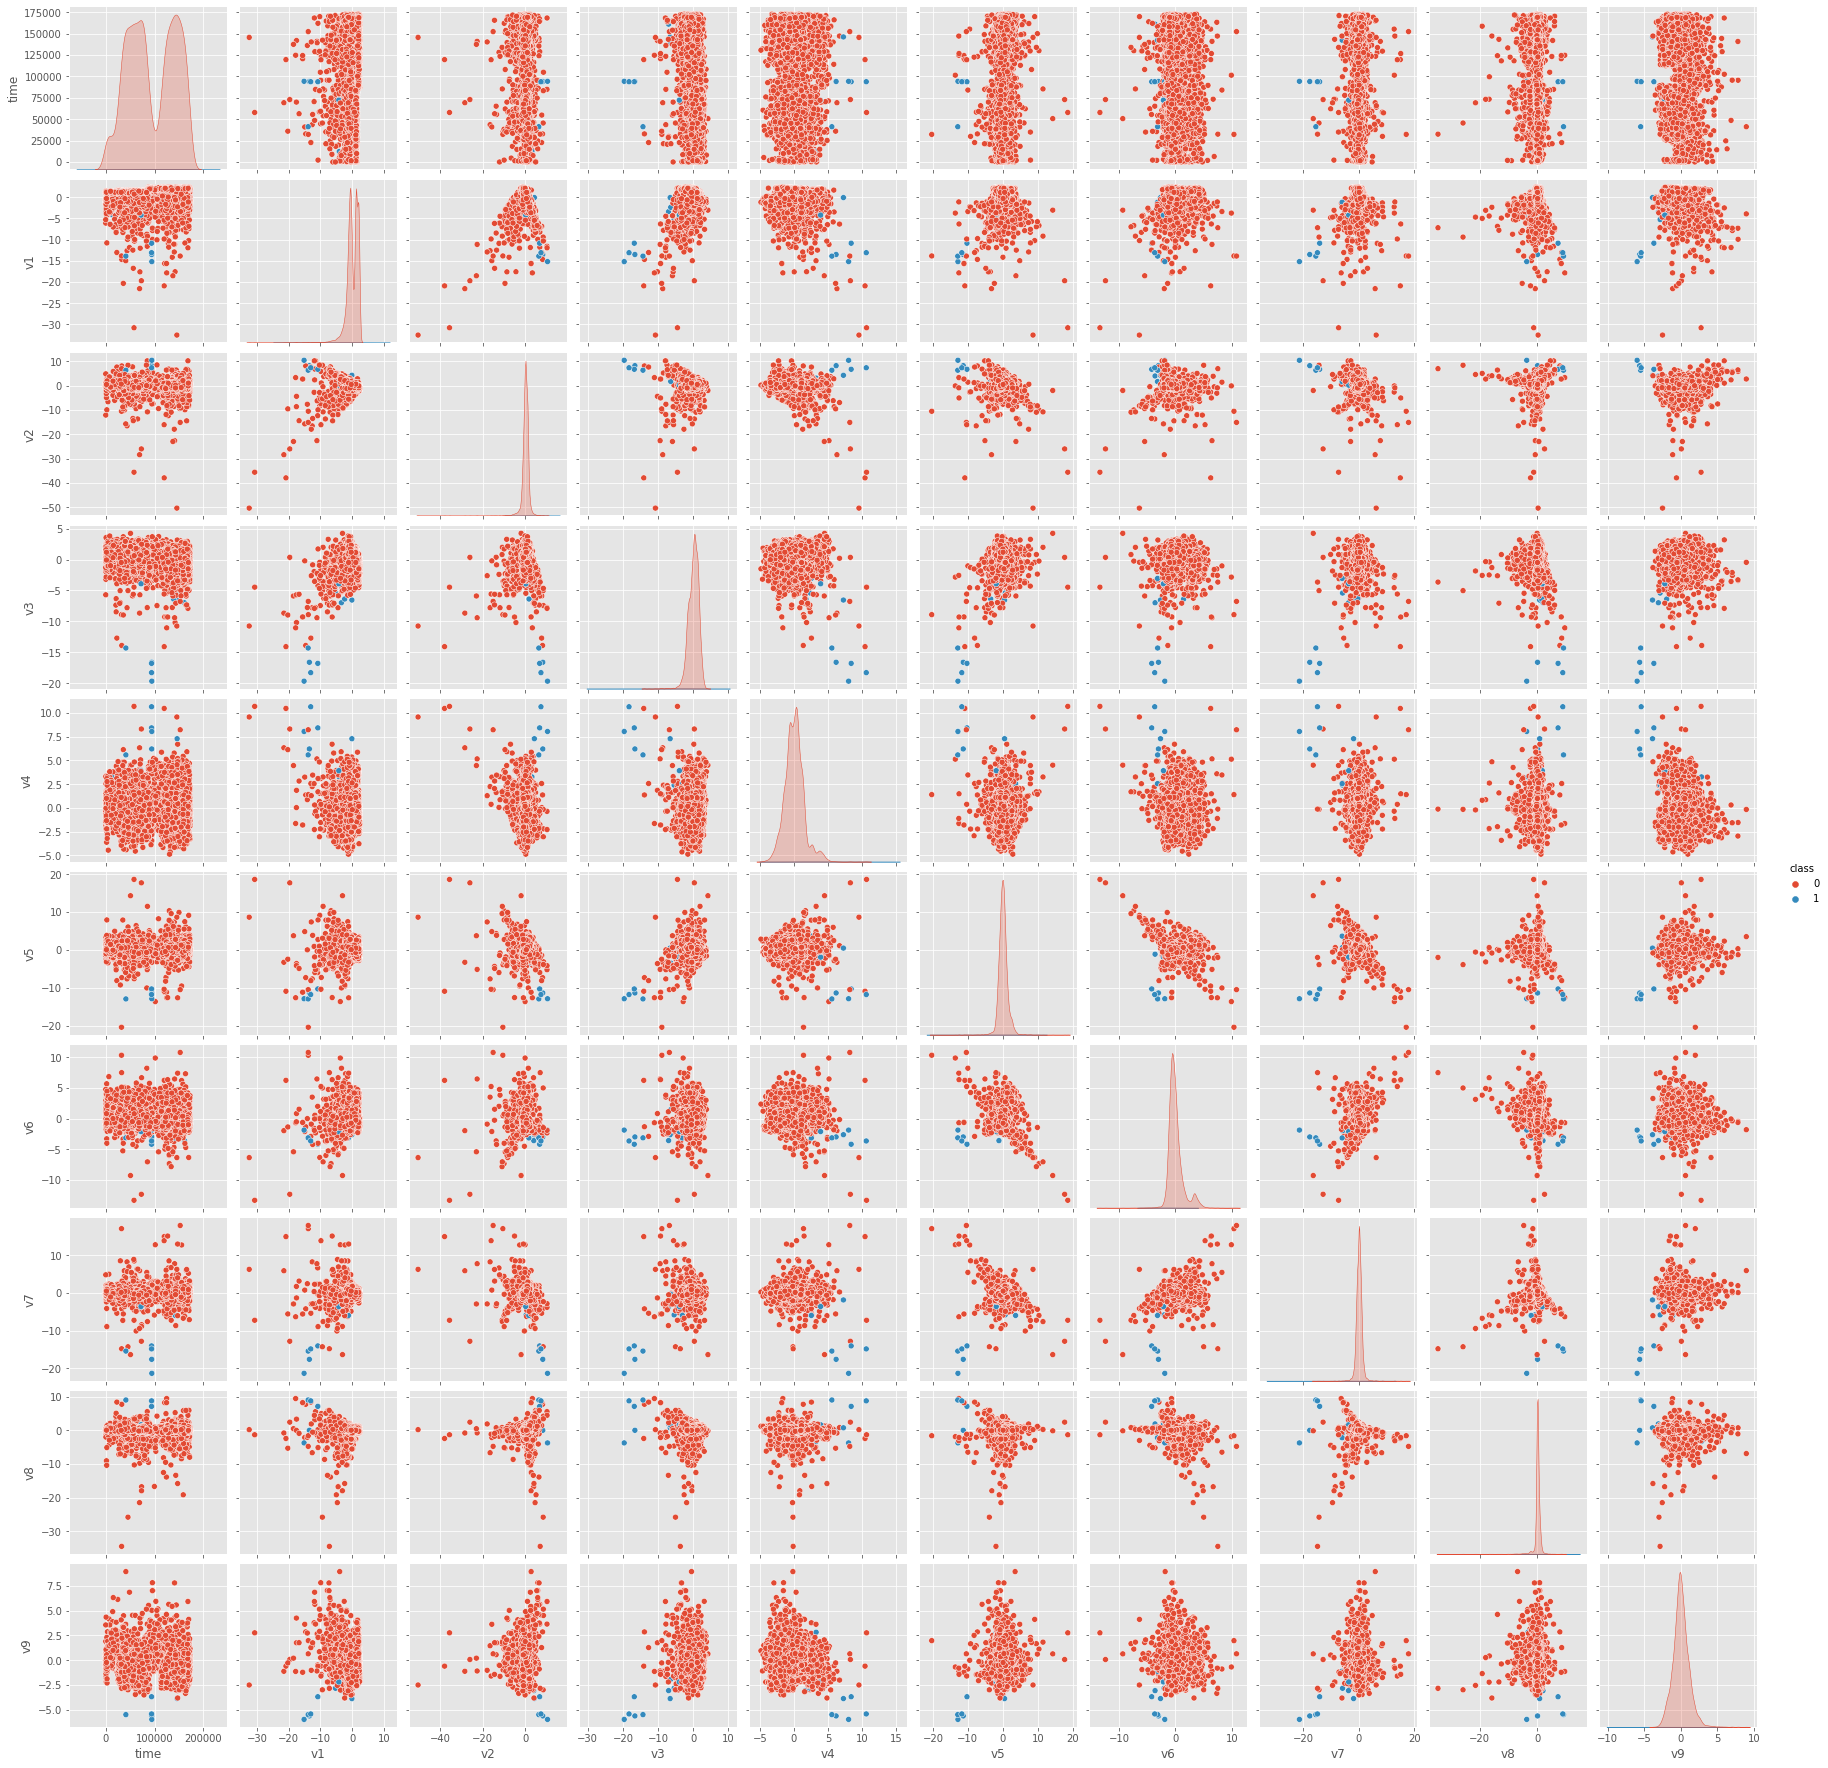

In [32]:
sns.pairplot(df[orig_feats[:10]+['class']].sample(10000, random_state=1), hue='class')

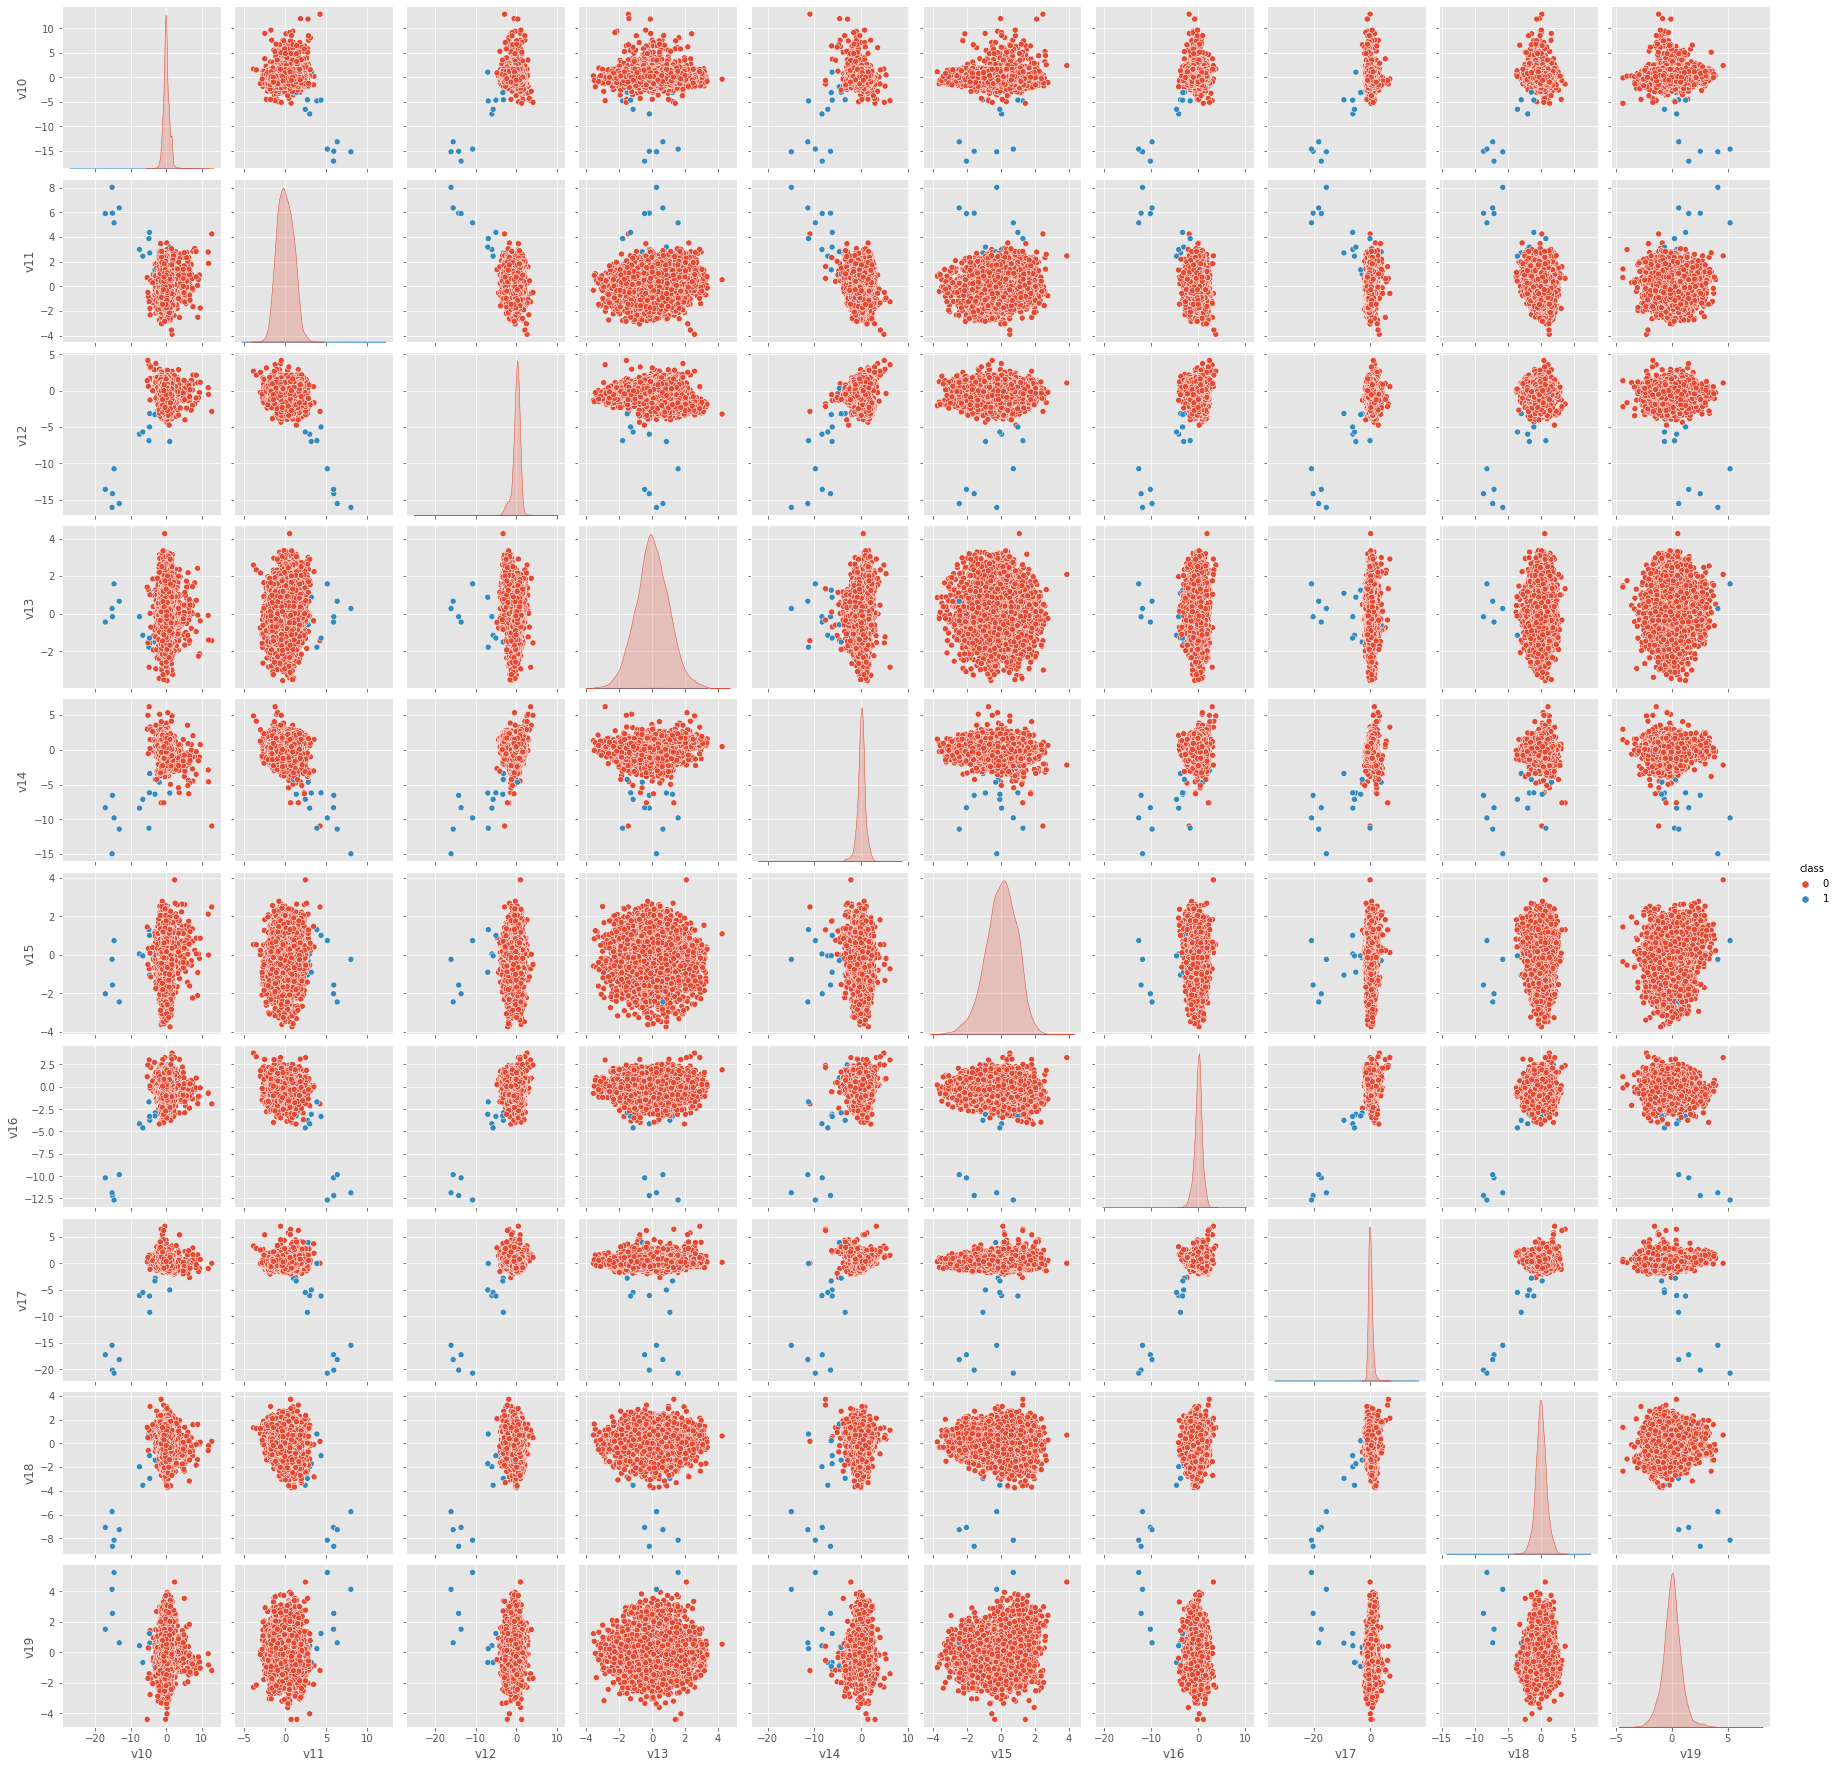

In [33]:
sns.pairplot(df[orig_feats[10:20]+['class']].sample(10000, random_state=1), hue='class')

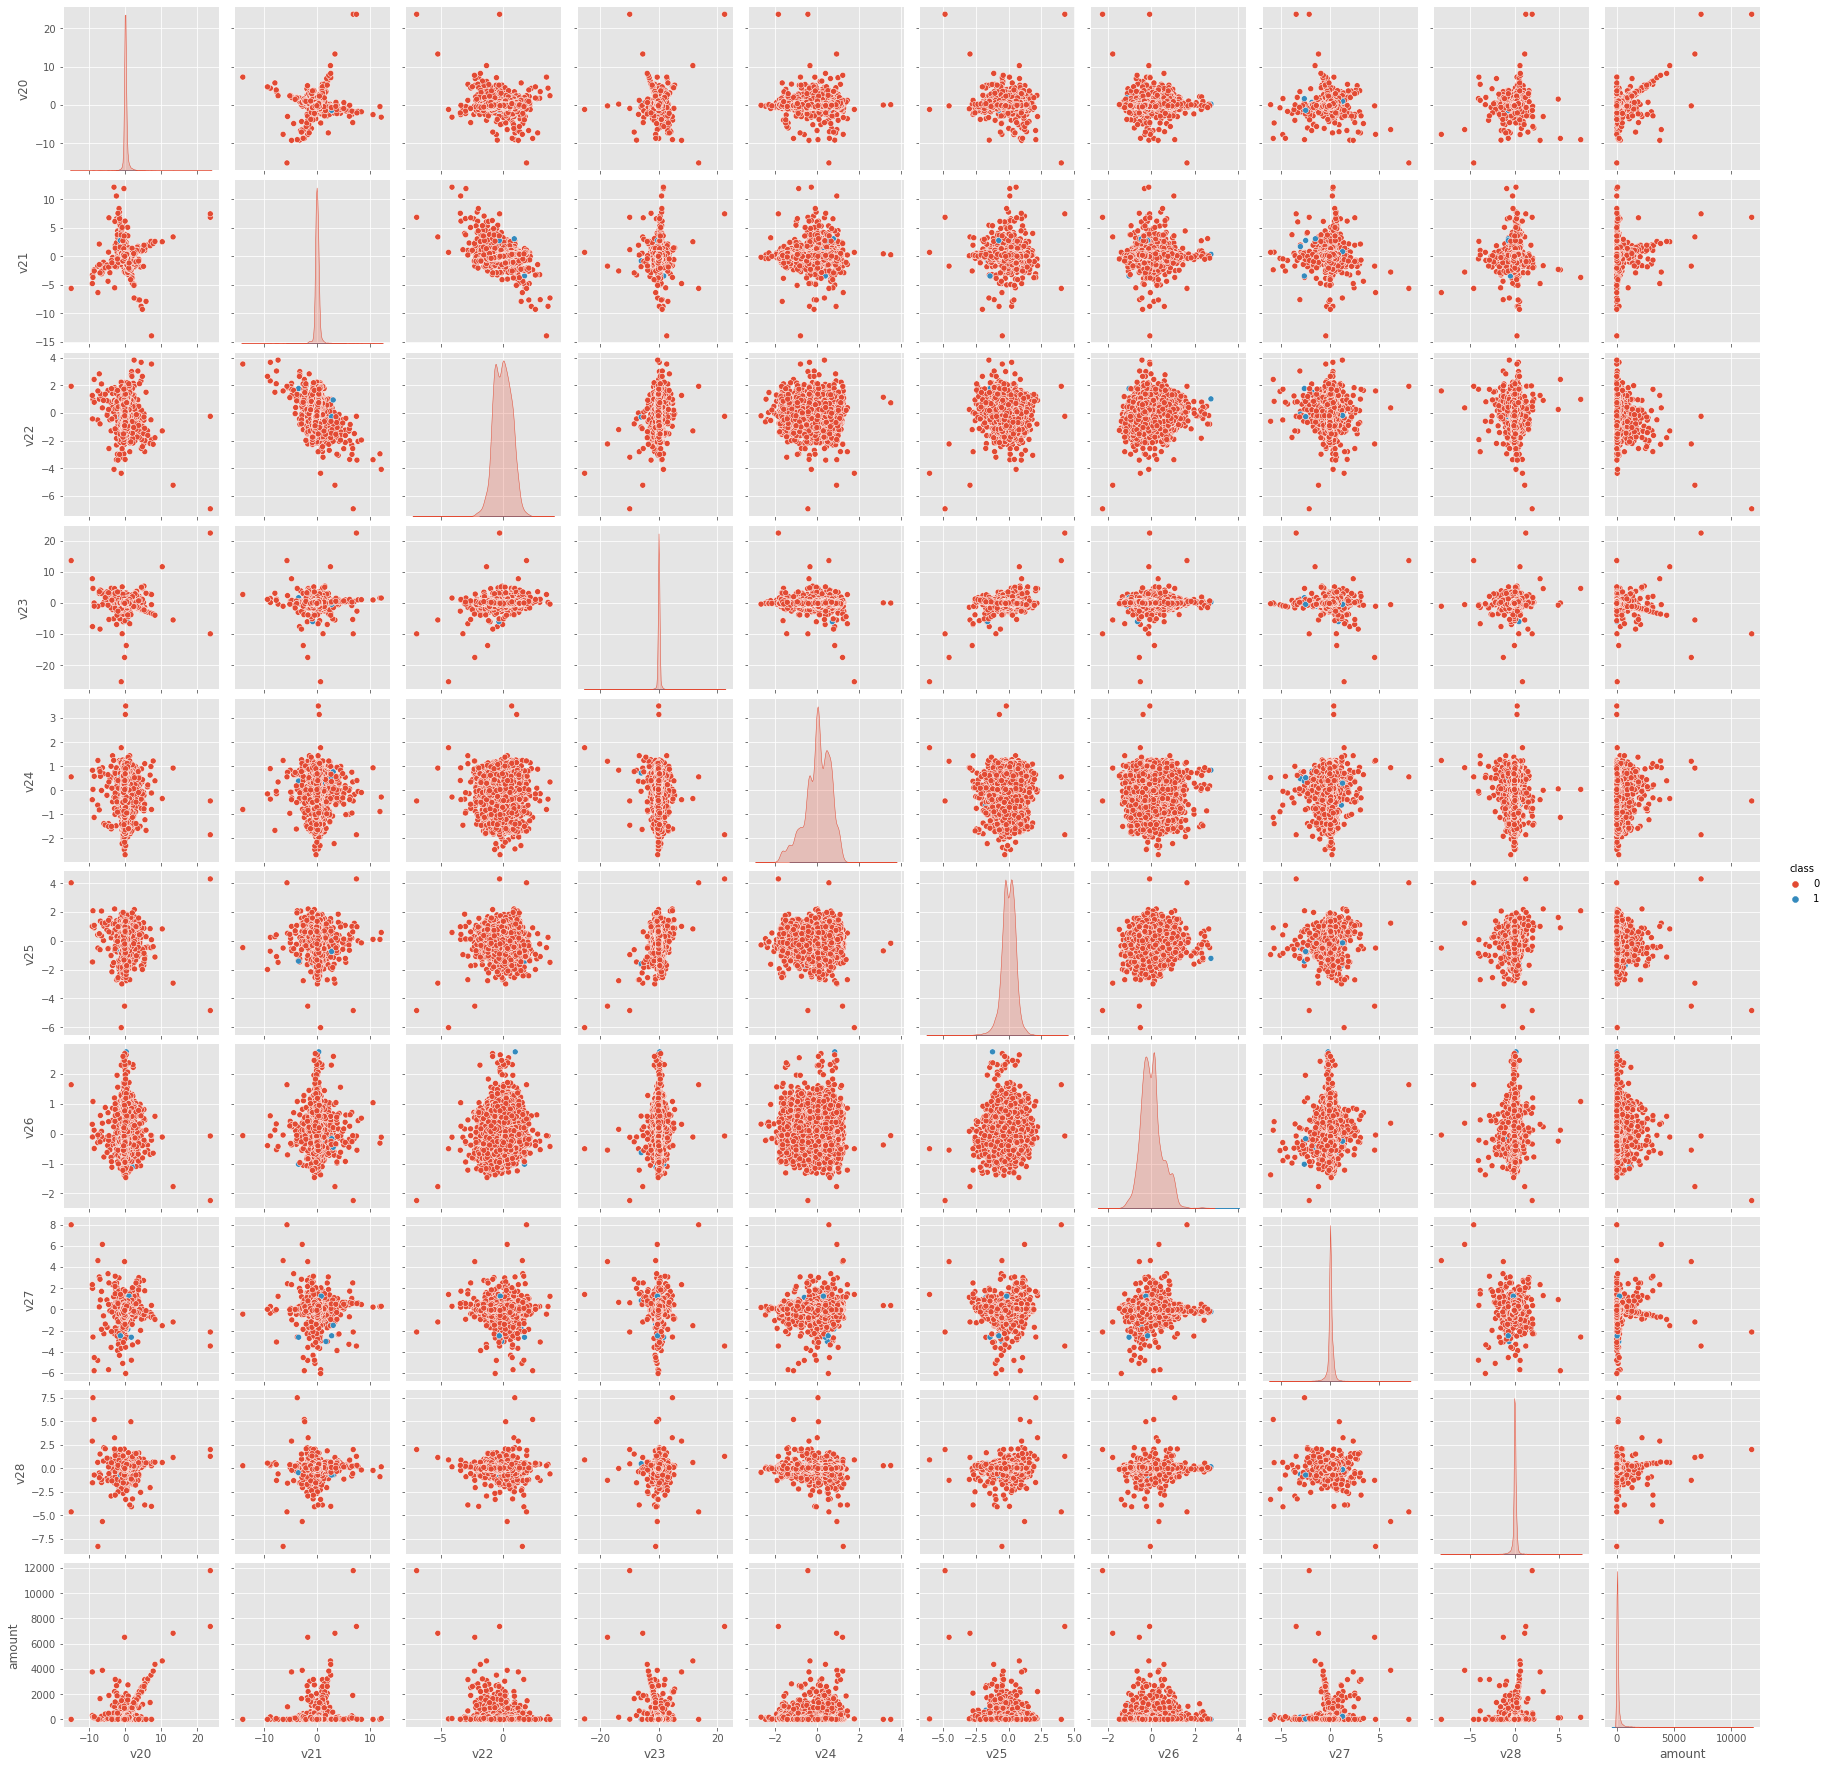

In [34]:
sns.pairplot(df[orig_feats[20:]+['class']].sample(10000, random_state=1), hue='class')

## Target Variable

In [8]:
target = 'class'

In [36]:
# Only 0.17% of the dataset is labelled as fraud
df[target].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: class, dtype: float64

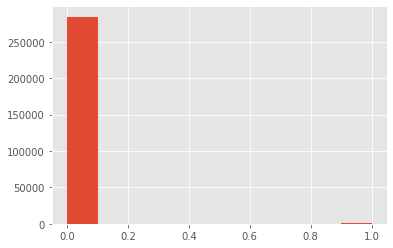

In [37]:
df[target].hist()

## Correlation Matrix

In [38]:
df_corr = df.corr()

In [39]:
df_corr.style.background_gradient().set_precision(2)

In [40]:
df.corr()['class'].sort_values()

v17      -0.326481
v14      -0.302544
v12      -0.260593
v10      -0.216883
v16      -0.196539
v3       -0.192961
v7       -0.187257
v18      -0.111485
v1       -0.101347
v9       -0.097733
v5       -0.094974
v6       -0.043643
time     -0.012323
v24      -0.007221
v13      -0.004570
v15      -0.004223
v23      -0.002685
v22       0.000805
v25       0.003308
v26       0.004455
amount    0.005632
v28       0.009536
v27       0.017580
v8        0.019875
v20       0.020090
v19       0.034783
v21       0.040413
v2        0.091289
v4        0.133447
v11       0.154876
class     1.000000
Name: class, dtype: float64

# Train, Test, Split

In [9]:
X = df[orig_feats]
y = df[target]

In [10]:
# Use stratify to ensure samples of fraud label are in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(213605, 30) (71202, 30) (213605,) (71202,)


In [43]:
y_train.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: class, dtype: float64

In [44]:
y_test.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: class, dtype: float64

# Modeling

## Predicting All Zeros

If we predict all 0's, what would be the AUC?

In [45]:
naive_preds = np.zeros(y_test.shape[0])
len(naive_preds)

71202

In [46]:
roc_auc_score(y_test, naive_preds)

0.5

In [47]:
print(classification_report(y_test, naive_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.00      0.00      0.00       123

    accuracy                           1.00     71202
   macro avg       0.50      0.50      0.50     71202
weighted avg       1.00      1.00      1.00     71202



## Naive Models 

Use cross validation and train naive models to see AUC scores and select model

In [48]:
num_boost_rounds = 1000
early_stopping_rounds = 10

initial_params = {'objective': 'binary:logistic', 'eval_metric': 'auc'}

In [49]:
logit_cv = cross_val_score(estimator=LogisticRegression(), 
                            X=X_train, 
                            y=y_train, 
                            scoring='roc_auc',
                            cv=StratifiedKFold(n_splits=5, random_state=1))

In [50]:
rf_cv = cross_val_score(estimator=RandomForestClassifier(),
                         X=X_train, 
                         y=y_train,
                         scoring='roc_auc',
                         cv=StratifiedKFold(n_splits=5, random_state=1))

In [51]:
xgb_cv = cross_val_score(estimator=XGBClassifier(num_boost_rounds=num_boost_rounds, 
                                                 early_stopping_rounds=early_stopping_rounds,
                                                 **initial_params),
                          X=X_train,
                          y=y_train,
                          scoring='roc_auc',
                          cv=StratifiedKFold(n_splits=5, random_state=1))

In [52]:
print(f'Logistic Regression CV Mean AUC score: {logit_cv.mean()}')
print(f'Random Forest CV Mean AUC score: {rf_cv.mean()}')
print(f'XGBoost CV Mean AUC score: {xgb_cv.mean()}')


Logistic Regression CV Mean AUC score: 0.9201020481870803
Random Forest CV Mean AUC score: 0.9509532293221501
XGBoost CV Mean AUC score: 0.9785085284136287


In [53]:
model_cv_results = {'logit': logit_cv, 'random_forest': rf_cv, 'xgb': xgb_cv}

Text(0.5, 1.0, 'AUC scores using Different Classification Algorithms')

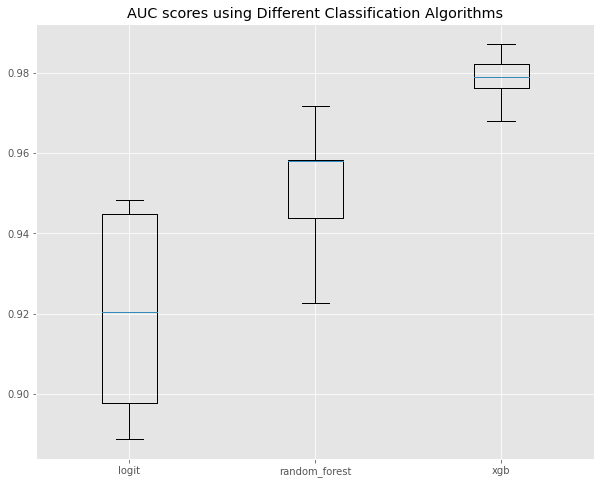

In [54]:
fig, ax = plt.subplots(figsize=(10,8))
plt.boxplot(model_cv_results.values())
ax.set_xticklabels(model_cv_results.keys())
plt.title('AUC scores using Different Classification Algorithms')

XGBoost performed the best, so select XGBoost as our model of choice going forward.

## Compare Sampling Methods

### Random Oversampling

Random Oversampling will sample the minority class with replacement until a defined threshold. The default sampling strategy will oversample the minority class until our new dataset has a 50/50 split between 0 and 1 labels.

In [55]:
oversamp_pipeline = imblearn.pipeline.Pipeline([('oversample', RandomOverSampler(random_state=42)),
                                                ('xgb', XGBClassifier(num_boost_rounds=num_boost_rounds, 
                                                                      early_stopping_rounds=early_stopping_rounds,
                                                                      **initial_params))])

### Random Undersampling

Random Undersampling will remove instances of the majority class until a defined threshold. The default sampling strategy will undersample the majority class (without replacement by default) until our new dataset has a 50/50 split between 0 and 1 labels.

In [56]:
undersamp_pipeline = imblearn.pipeline.Pipeline([('undersample', RandomUnderSampler(random_state=42)),
                                                 ('xgb', XGBClassifier(num_boost_rounds=num_boost_rounds, 
                                                                       early_stopping_rounds=early_stopping_rounds,
                                                                       **initial_params))])

### Oversampling - SMOTE

In [57]:
smote_pipeline = imblearn.pipeline.Pipeline([('smote', SMOTE(random_state=42)),
                                             ('xgb', XGBClassifier(num_boost_rounds=num_boost_rounds, 
                                                                   early_stopping_rounds=early_stopping_rounds,
                                                                   **initial_params))])

### Cross Validation to Compare Sampling Methods

In [58]:
sampling_methods = {'random_oversampling': oversamp_pipeline,
                    'random_undersampling': undersamp_pipeline,
                    'smote': smote_pipeline}

In [59]:
sampling_cv_results = {}

for method, pipeline in sampling_methods.items():
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=5, random_state=1), scoring='roc_auc')
    sampling_cv_results[method] = cv_results
    print(method, cv_results.mean())

ValueError: ignored

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plt.boxplot(sampling_cv_results.values())
ax.set_xticklabels(sampling_cv_results.keys())
plt.title('AUC scores of XGB Classifier using Different Sampling Methods')

# Bayesian Hyperparameter Tuning using Hyperopt

In [62]:
# Set up grid for hyperopt
space = {
    'max_depth': hp.quniform('max_depth', 4, 10, 2),
    'min_child_weight': hp.quniform('min_child_weight', 1, 20, 2),
    'gamma': hp.quniform('gamma', 0, 5, 0.5),
    'subsample': hp.uniform('subsample', 0.5, 0.9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.9),
    'eta': hp.uniform('eta', 0.01, 0.3),
    'objective': 'binary:logistic',
    'eval_metric': 'auc'
}

In [63]:
# Objective function
def objective(params):
    params = {'max_depth': int(params['max_depth']),
              'min_child_weight': int(params['min_child_weight']),
              'gamma': params['gamma'],
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'eta': params['eta'],
              'objective': params['objective'],
              'eval_metric': params['eval_metric']}
    
    xgb_clf = XGBClassifier(num_boost_rounds=num_boost_rounds, 
                            early_stopping_rounds=early_stopping_rounds,
                            **params)
    
    best_score = cross_val_score(xgb_clf, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=3).mean()
    
    loss = 1 - best_score 
    
    return loss

In [64]:
%%time
best_result = fmin(fn=objective, space=space, max_evals=20, 
                   rstate=np.random.RandomState(42), algo=tpe.suggest)

100%|██████████| 20/20 [46:46<00:00, 140.33s/it, best loss: 0.01882928211744106]


In [12]:
best_result = {'colsample_bytree': 0.7877505702629413,
 'eta': 0.11532889782582927,
 'gamma': 2.5,
 'max_depth': 6.0,
 'min_child_weight': 8.0,
 'subsample': 0.8516543548792181}

best_result

{'colsample_bytree': 0.7877505702629413,
 'eta': 0.11532889782582927,
 'gamma': 2.5,
 'max_depth': 6.0,
 'min_child_weight': 8.0,
 'subsample': 0.8516543548792181}

In [14]:
best_params = best_result
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])
best_params['gamma'] = best_params['gamma']
best_params['colsample_bytree'] = round(best_params['colsample_bytree'], 1)
best_params['eta'] = round(best_params['eta'], 1)
best_params['subsample'] = round(best_params['subsample'], 1)
best_params

{'colsample_bytree': 0.8,
 'eta': 0.1,
 'gamma': 2.5,
 'max_depth': 6,
 'min_child_weight': 8,
 'subsample': 0.9}

# Evaluating Final Model Performance

## Train Final Model with Optimal Hyperparameters

In [17]:
num_boost_rounds = 1000
early_stopping_rounds = 10

final_model = imblearn.pipeline.Pipeline([('smote', SMOTE(random_state=1)),
                                          ('xgb', XGBClassifier(num_boost_rounds=num_boost_rounds,
                                                                early_stopping_rounds=early_stopping_rounds, 
                                                                **best_params))])

In [18]:
%%time
final_model.fit(X_train, y_train)

CPU times: user 3min 16s, sys: 389 ms, total: 3min 16s
Wall time: 3min 16s


Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=1, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, early_stopping_rounds=10,
                               eta=0.1, gamma=2.5, learning_rate=0.1,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=8, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               num_boost_rounds=1000,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0,

In [19]:
%%time
final_preds = final_model.predict_proba(X_test)[:,1]

ValueError: ignored

## Save Final Model Predictions to .csv

In [ ]:
test = pd.merge(X_test, y_test, left_index=True, right_index=True)
test.head()

In [ ]:
test.shape

In [ ]:
df_preds = test.copy()
df_preds['fraud_score'] = final_preds

In [ ]:
df_preds.head()

In [ ]:
df_preds['fraud_score'].describe()

In [ ]:
df_preds.to_csv('./final_model_preds.csv', index=False)

## Final Model Performance

In [ ]:
roc_auc_score(y_test, final_preds)

In [ ]:
print(classification_report(y_test, final_preds.round()))

## Final Model Feature Importances

In [ ]:
explainer = shap.TreeExplainer(final_model[1])

In [ ]:
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type='bar')